In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
df=pd.read_excel("C:/Users/heena/OneDrive/Desktop/Cornell/JOB/personal project/5_15_20_MENG/nutVal.xlsx",sheet_name="combination",dtype="object", names = ['Dates', 'Quantity', 'Pounds', 'Value', 'Nutrition category'])
print(df.head(2))
print(df.shape)
all_times = pd.date_range(start='2016-01-01', end='2018-05-23', freq='D')
all_times

         Dates Quantity Pounds Value Nutrition category
0   05/23/2018      380    380     0             cereal
1   05/22/2018      365    365     0             cereal
(3181, 5)


DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',
               '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21',
               '2018-05-22', '2018-05-23'],
              dtype='datetime64[ns]', length=874, freq='D')

In [2]:
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.set_index('Dates')
s = pd.Series(df['Pounds'], index=df.index )

In [3]:
s = s.resample('d').sum()
s.drop(s[s == False].index, inplace=True)
df1 = pd.DataFrame({'Dates':s.index, 'Pounds':s.values})

print(df1.head(5))
print(df1.shape)


df1 = df1.set_index('Dates')
all_times = pd.date_range(start='2016-01-01', end='2018-05-23', freq='D')
all_times
df1 = df1.reindex(all_times, fill_value=0)
df1 = df1.reset_index()

df1 = df1.rename(columns={'index': 'Dates'})
a = list(np.arange(365))
a = 2*a
a = a + list(np.arange(144))
df1['num'] = a
print(df1.head(5))
print(df1.shape)



       Dates  Pounds
0 2016-01-04  3036.0
1 2016-01-05  6739.0
2 2016-01-06  3565.0
3 2016-01-11   949.0
4 2016-01-12  5917.0
(570, 2)
       Dates  Pounds  num
0 2016-01-01     0.0    0
1 2016-01-02     0.0    1
2 2016-01-03     0.0    2
3 2016-01-04  3036.0    3
4 2016-01-05  6739.0    4
(874, 3)


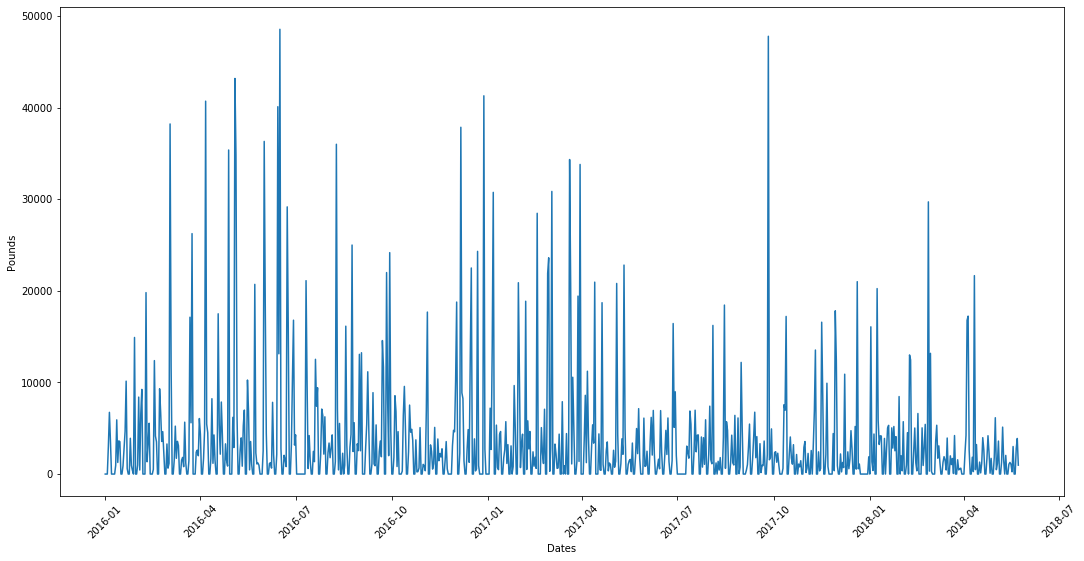

In [4]:
plt.figure(figsize = (18,9))
plt.plot(df1.Dates, df1.Pounds)
plt.xlabel('Dates')
plt.ylabel('Pounds')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Store the quantity data in a variable
Pounds_Supply = df1.loc[:, 'Pounds'].values.astype(float)
num = df1.loc[:, 'num'].values.astype(float)


# Split the data into testing data and training data
train_data = Pounds_Supply[:730]
test_data = Pounds_Supply[730:]
##Normalizing the Data
#Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
# Train the Scaler with training data and smooth data
smoothing_window_size = 700
for i in range(0, 175,smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[i+smoothing_window_size:,:])
train_data[i+smoothing_window_size:,:] = scaler.transform(train_data[i+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

all_quant_data = np.concatenate([train_data,test_data],axis=0)
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

EMA = 0.0
gamma = 0.1
for ti in range(874):
  EMA = gamma*all_quant_data[ti] + (1-gamma)*EMA
  all_quant_data[ti] = EMA
    
    
#   EMA = gamma*all_quant_data[ti] + (1-gamma)*EMA
#   all_quant_data[ti] = EMA

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

# EMA = 0.0
# gamma = 0.1
# for ti in range(170):
#   EMA = gamma*test_data[ti] + (1-gamma)*EMA
#   test_data[ti] = EMA


MSE error for standard averaging: 0.00024


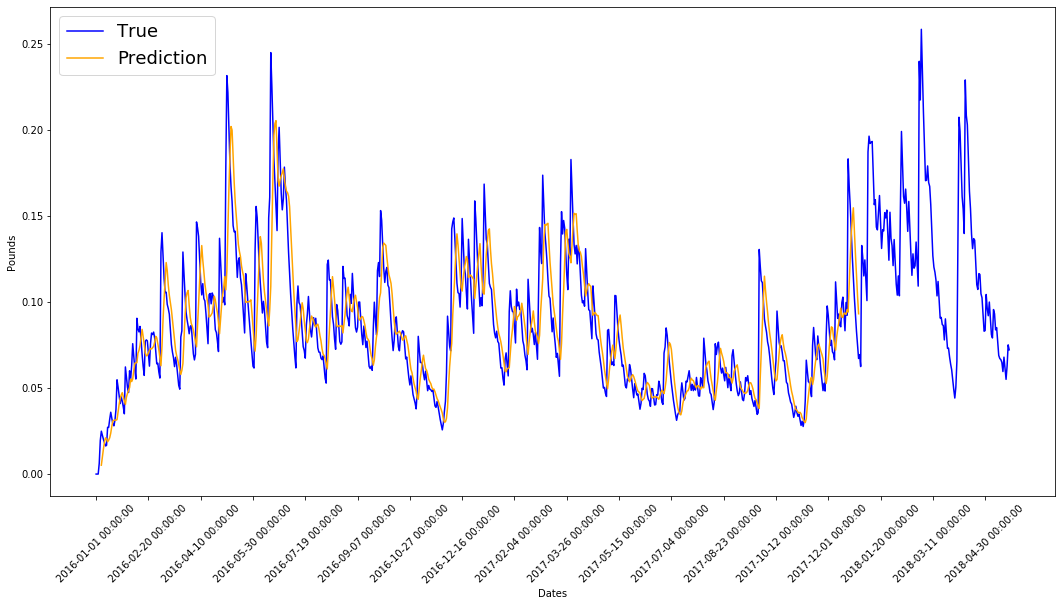

In [7]:

# Used for visualization and test purposes
# all_quant_data = np.concatenate([train_data,test_data],axis=0)
train_data = all_quant_data[:730]
test_data = all_quant_data[730:]
## Using the Standard Average method to do prediction 
window_size = 5
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df1.loc[pred_idx,'Dates']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

## Plot the Result

plt.figure(figsize = (18,9))
plt.plot(range(df1.shape[0]),all_quant_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df1.shape[0],50),df1['Dates'].loc[::50],rotation=45)
plt.xlabel('Dates')
plt.ylabel('Pounds')
plt.legend(fontsize=18)

# plt.xlim(0,119)
# plt.ylim(0, 0.2)

plt.show()

In [8]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.4

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.1*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


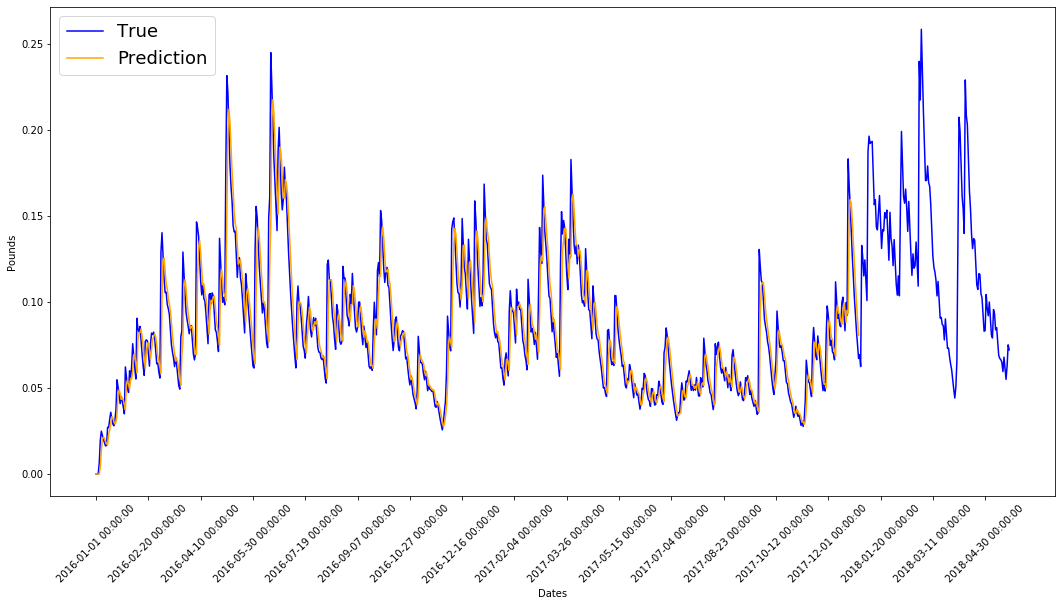

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df1.shape[0]),all_quant_data,color='b',label='True')
# plt.plot(range(400),all_quant_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,df1.shape[0],50),df1['Dates'].loc[::50],rotation=45)
# plt.xticks(range(0,400,50),df1['Dates'].loc[::50],rotation=45)
plt.xlabel('Dates')
plt.ylabel('Pounds')
plt.legend(fontsize=18)
# plt.xlim(0,119)
# plt.ylim(0,0.2) 
plt.show()

In [10]:
class DataGeneratorSeq(object):

    def __init__(self,Quantity,batch_size,num_unroll):
        self._Quantity = Quantity
        self._Quantity_length = len(self._Quantity) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._Quantity_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._Quantity_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._Quantity[self._cursor[b]]
            batch_labels[b]= self._Quantity[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._Quantity_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._Quantity_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.10083631 0.07158238 0.09180495 0.05054667]

	Output: [0.01950453 0.07728908 0.07158238 0.07528844 0.05054667]


Unrolled index 1
	Inputs:  [0.         0.09324033 0.07993073 0.08262445 0.07891046]

	Output: [0.02489551 0.08587676 0.08327767 0.07528844 0.07101941]


Unrolled index 2
	Inputs:  [0.         0.08587676 0.08134869 0.0906326  0.07101941]

	Output: [0.00625206 0.08587676 0.08258169 0.0906326  0.05402501]


Unrolled index 3
	Inputs:  [0.00625206 0.07728908 0.08327767 0.08156934 0.06391747]

	Output: [0.01950453 0.07728908 0.07432352 0.08156934 0.05402501]


Unrolled index 4
	Inputs:  [0.01950453 0.06956018 0.08258169 0.07528844 0.06002778]

	Output: [0.01814883 0.06956018 0.07432352 0.07528844 0.06002778]


In [11]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 20 # Number of time steps you look into the future.
batch_size = 50 # Number of samples in a batch
num_nodes = [5, 2] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.1 # dropout amount

tf.reset_default_graph() 

In [12]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [13]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [14]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	All done


In [16]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [17]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 144 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(730, 874, 144).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

        # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
              # Only calculate x_axis values in the first validation epoch
                x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_quant = all_quant_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_quant).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current_quant = all_quant_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current_quant).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):
            
                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

#                 mse_test_loss += 0.5*(pred-all_quant_data[w_i+pred_i])**2
                mse_test_loss = np.mean((pred-all_quant_data[w_i+pred_i])**2)
                
            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

Initialized
Average loss at step 1: 0.132335
	Test MSE: 0.00003
	Finished Predictions


c:\users\heena\.conda\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Average loss at step 2: 0.100796
	Test MSE: 0.00002
	Finished Predictions
Average loss at step 3: 0.098301
	Test MSE: 0.00002
	Finished Predictions
Average loss at step 4: 0.072913
	Test MSE: 0.00002
	Finished Predictions
Average loss at step 5: 0.065078
	Test MSE: 0.00001
	Finished Predictions
Average loss at step 6: 0.053541
	Test MSE: 0.00001
	Finished Predictions
Average loss at step 7: 0.049438
	Test MSE: 0.00001
	Finished Predictions
Average loss at step 8: 0.041525
	Test MSE: 0.00001
	Finished Predictions
Average loss at step 9: 0.039318
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 10: 0.030261
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 11: 0.031558
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 12: 0.022905
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 13: 0.025718
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 14: 0.024076
	Test MSE: 0.00000
	Finished Predictions
Average loss at step 15: 0.022831

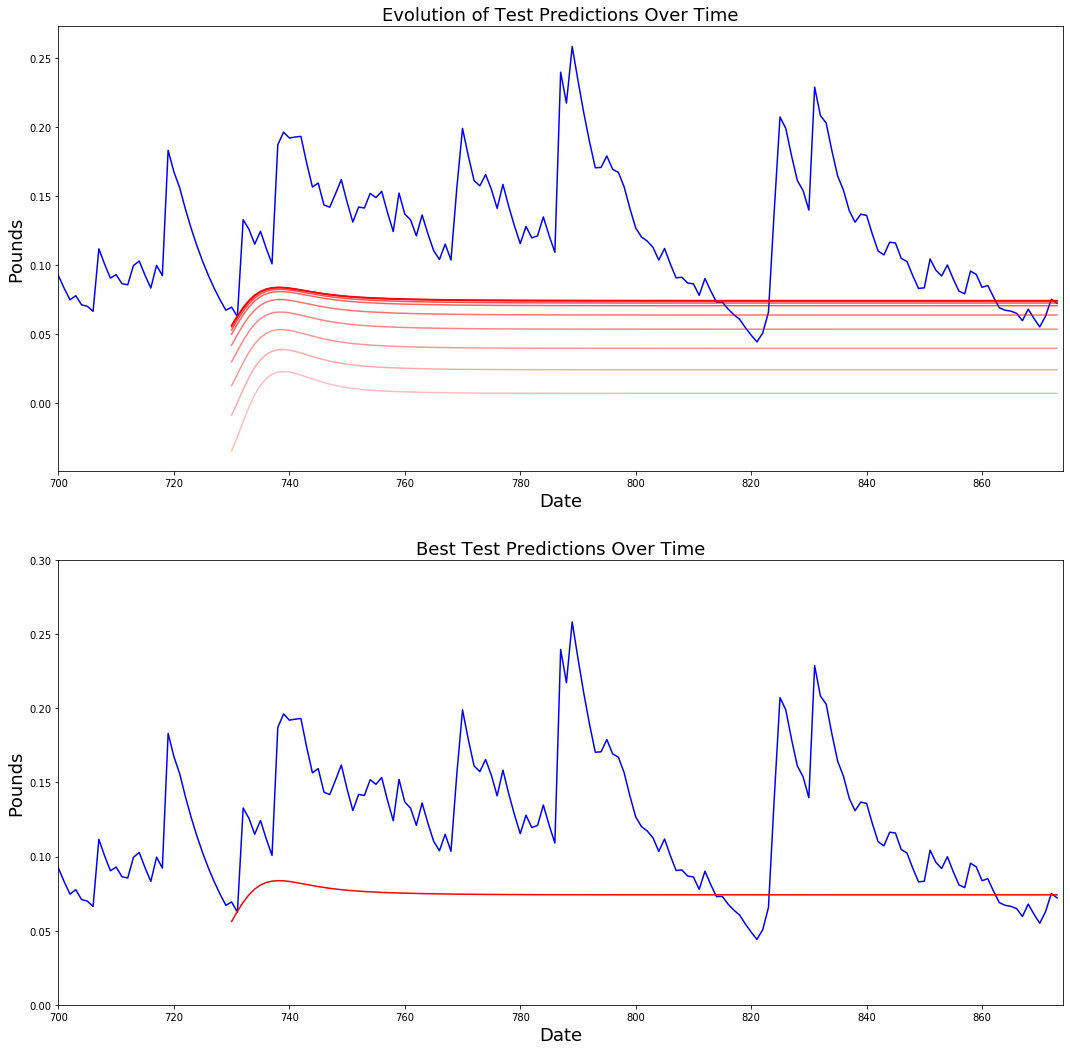

In [18]:
best_prediction_epoch = 26 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df1.shape[0]),all_quant_data,color='b')
# plt.plot(range(400),all_quant_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Pounds',fontsize=18)
plt.xlim(700,874)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df1.shape[0]),all_quant_data,color='b')
# plt.plot(range(400),all_quant_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Pounds',fontsize=18)
plt.xlim(700,874)
plt.ylim(0,0.3)
plt.show()